In [63]:
import os
import math
import optparse
import time
import sys
import numpy as np
from scipy.stats import expon
from scipy.stats import poisson
from scipy import stats  
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import root_numpy as rn
import ROOT as rt


from time import perf_counter
import gc

#energyDep_hit = 6 #keV
ion_pot = 0.0462 #keV
#GEM_gain = 123
GEM_gain = 400 #330
extraction_eff = 0.33

## from https://arxiv.org/pdf/2007.00608.pdf field 0.5 kV/cm
diff_const_sigma0T = 0.0784  # diffusion constant [mm]^2
diff_coeff_T = 0.0196        # diffusion parameter [mm/sqrt(cm)]^2
diff_const_sigma0L = 0.0676
diff_coeff_L = 0.0144


z_gem = 555. #mm

x_dim = 350 #mm
y_dim = 350 #mm
x_pix = 2304
y_pix = 2304
z_vox_dim = 0.1 #mm

sensor_size = 14.976 #mm
camera_aperture = 0.95

photons_per_el = 0.07
counts_per_photon = 2
demag=y_dim/sensor_size
a=camera_aperture
omega=1./math.pow((4*(demag+1)*a),2)   # solid angle ratio
print("omega = %f"% omega)

A = 1./0.68
beta = 2.5e-5
l = 1000 #mm

saturation = 1
 

print("Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root")
inputfile = rt.TFile.Open("/home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root")
tree = inputfile.Get("nTuple")

def NelGEM2(energyDep,z_hit):
    n_ioniz_el=(energyDep/ion_pot)
    drift_l = np.abs(z_hit-z_gem)
    #print("distance from the gem %d mm"%drift_l)
    n_ioniz_el_mean = n_ioniz_el*np.exp(-drift_l/l) 
    primary=poisson(n_ioniz_el_mean)           # poisson distribution for primary electrons
    n_ioniz_el=primary.rvs()                   # number of primary electrons
    #n_ioniz_el=n_ioniz_el_mean
    #n_ioniz_el_array = np.append(n_ioniz_el_array,n_ioniz_el)
    #print('n ionization electrons = %d'%(n_ioniz_el))
    n_el_oneGEM=0                              # number of secondary electrons
    gain1=expon(loc=0,scale=GEM_gain)  # exponential distribution for the GAIN in the first GEM foil
    for k in range(0,n_ioniz_el):
        nsec = gain1.rvs()*extraction_eff      # number of secondary electrons in the first GEM multiplication for each ionization electron
        n_el_oneGEM += nsec
        #nsec_1GEM_array = np.append(nsec_1GEM_array,nsec)
        #print ('--   loop on ioniz el, k= %d - nsec= %d - nel_onegem= %d'%(k,nsec,n_el_oneGEM))

    # total number of secondary electrons considering the gain in the 2nd GEM foil
    n_tot_el=n_el_oneGEM*GEM_gain*extraction_eff
    #print("Electrons after 2nd GEM: %d"%n_tot_el)


    return n_tot_el

def cloud_smearing3D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list(); Z=list() 
    X*=0; Y*=0; Z*=0
    nel=NelGEM2(energyDep_hit,z_hit)

    ## arrays of positions of produced electrons after GEM2
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Z=(np.random.normal(loc=(z_hit-255.), scale=np.sqrt(diff_const_sigma0L+diff_coeff_L*(np.abs(z_hit-z_gem))/10.), size=int(nel)))   
    #print("distance from the GEM : %f cm"%((np.abs(z_hit-z_gem))/10.))
    return X, Y, Z

def ph_smearing2D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list()
    X*=0; Y*=0
    ## electrons in GEM2
    nel = NelGEM2(energyDep_hit,z_hit)
    ## photons in GEM3
    nph = nel * GEM_gain *omega * photons_per_el * counts_per_photon
    ## arrays of positions of produced photons
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    return X, Y

    
def Nph_saturation(histo_cloud):
    Nph_array = np.zeros((histo_cloud.GetNbinsX(),histo_cloud.GetNbinsY()))
    Nph_tot = 0
    for i in range(1120,1180):
        for j in range(1120,1180):
            hout = 0
            for k in range(1,histo_cloud.GetNbinsZ()+1):
                hin = histo_cloud.GetBinContent(i,j,k)
                #electrons = poisson(hin)
                #nel_in = electrons.rvs() 
                nel_in = hin
                #if nel_in==0:
                #    continue
                #else:
                #print(hin)
                ## sum voxels along z
                #gain3=expon(loc=0,scale=GEM_gain)  # exponential distribution for the GAIN of 3rd GEM
                #gain_rnd = gain3.rvs()     
                #print("gain extracted = %d"%gain_rnd)
                hout += (nel_in * A * GEM_gain)/(1 + beta * GEM_gain  * nel_in) 
                #hout += (nel_in * A * gain_rnd)/(1 + beta * gain_rnd  * nel_in) 
                

            nmean_ph= hout * omega * photons_per_el * counts_per_photon     # mean total number of photons
            photons=poisson(nmean_ph)                    # poisson distribution for photons
            n_ph=photons.rvs()  
            Nph_array[i-1][j-1] = n_ph
            Nph_tot += Nph_array[i-1][j-1]
            #if hout>0:
            #    print("number final electrons per voxel: %f"%hout)
            
    return Nph_tot, Nph_array




omega = 0.000117
Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root


In [ ]:
#nph_array = np.zeros(tree.GetEntries())
nph_array = np.zeros(1000)
nph_nosat = np.zeros(1000)

#for iev in range(0,tree.GetEntries()):
for iev in range(0,1000):
    t1_start = perf_counter() 

    tree.GetEntry(iev)
    if (iev%10==0): 
        print("Processing event %d"%iev)
    numhits = tree.numhits

    histname = "histo_cloud_pic_"+str(int(iev)) 
    histo_cloud = rt.TH3I(histname,"",x_pix,0,x_pix-1,y_pix,0,y_pix-1,100,0,100)
    histo_cloud_draw = rt.TH2I("histoclouddraw"+str(int(iev)),"",60,1120,1180,60,1120,1180) #100,0,100)

    #print("created histo_cloud")
    
    ## with saturation
    if (saturation>0):
        tot_el_G2 = 0
        for ihit in range(0,tree.numhits):
            #print("Processing hit %d of %d"%(ihit,tree.numhits))

            ## here swapping X with Z beacuse in geant the drift axis is X
            S3D = cloud_smearing3D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])

            for j in range(0, len(S3D[0])):
                histo_cloud.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim, (0.5*y_dim+S3D[1][j])*y_pix/y_dim, (0.5*histo_cloud.GetNbinsZ()*z_vox_dim+S3D[2][j])/z_vox_dim ) 
                histo_cloud_draw.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim,(0.5*y_dim+S3D[1][j])*y_pix/y_dim) # (0.5*histo_cloud.GetNbinsZ()*z_vox_dim+S3D[2][j])/z_vox_dim)    
                tot_el_G2+=1
                
        #tot_el_G2 = histo_cloud.Integral()
    
        # 2d map of photons applying saturation effect
        result_GEM3 = Nph_saturation(histo_cloud)
        array2d_Nph = result_GEM3[1]
        tot_ph_G3 = result_GEM3[0] #np.sum(array2d_Nph)

        print("tot num of sensor counts after GEM3 including saturation: %d"%(tot_ph_G3))
        print("tot num of sensor counts after GEM3 without saturation: %d"%(tot_el_G2*GEM_gain* omega * photons_per_el * counts_per_photon))
        print("Gain GEM3 = %f   Gain GEM3 saturated = %f"%(GEM_gain, tot_ph_G3/(tot_el_G2*omega * photons_per_el * counts_per_photon) ))   

    ## no saturation
    else:
        tot_ph_G3=0
        for ihit in range(0,tree.numhits):
            ## here swapping X with Z beacuse in geant the drift axis is X
            S2D = ph_smearing2D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])
            
            #for j in range(0, len(S2D[0])):
            for t in range(0, len(S2D[0])):
                tot_ph_G3+=1

        #print("tot num of sensor counts after GEM3 without saturation: %d"%(tot_ph_G3))

       

    nph_array[iev] = tot_ph_G3
    nph_nosat[iev] = tot_el_G2*GEM_gain* omega * photons_per_el * counts_per_photon
    t1_stop = perf_counter() 
    
    print("Time event %d s"%(t1_stop-t1_start))

Processing event 0
tot num of sensor counts after GEM3 including saturation: 7272
tot num of sensor counts after GEM3 without saturation: 10894
Gain GEM3 = 400.000000   Gain GEM3 saturated = 266.995233
Time event 15 s
tot num of sensor counts after GEM3 including saturation: 6605
tot num of sensor counts after GEM3 without saturation: 9151
Gain GEM3 = 400.000000   Gain GEM3 saturated = 288.691388
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 7266
tot num of sensor counts after GEM3 without saturation: 10755
Gain GEM3 = 400.000000   Gain GEM3 saturated = 270.230520
Time event 16 s
tot num of sensor counts after GEM3 including saturation: 7085
tot num of sensor counts after GEM3 without saturation: 10700
Gain GEM3 = 400.000000   Gain GEM3 saturated = 264.857335
Time event 16 s
tot num of sensor counts after GEM3 including saturation: 6967
tot num of sensor counts after GEM3 without saturation: 9923
Gain GEM3 = 400.000000   Gain GEM3 saturated = 280.817238
Time

created final_image


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


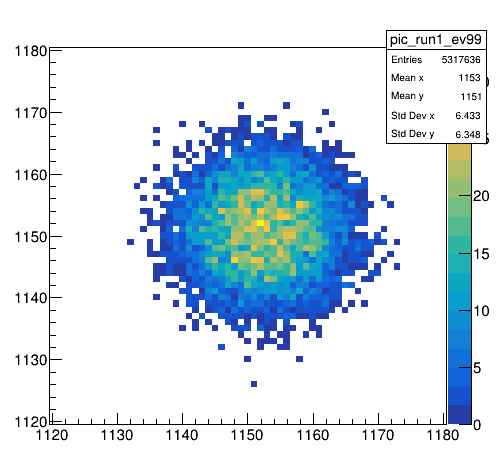

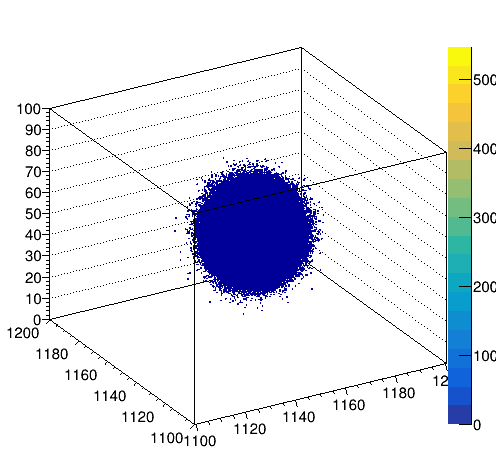

In [69]:
rt.gStyle.SetCanvasPreferGL(1);

## create final image
final_image=rt.TH2I('pic_run1_ev'+str(iev), '', x_pix, 0, x_pix-1, y_pix, 0, y_pix-1)
print("created final_image")
final_image=rn.array2hist(array2d_Nph, final_image)
    
c = rt.TCanvas("c","",500,500)
final_image.GetXaxis().SetRangeUser(1120,1180)
final_image.GetYaxis().SetRangeUser(1120,1180)

final_image.Draw("colz")
c.Draw()

c2 = rt.TCanvas("c2","",500,500)
histo_cloud.GetXaxis().SetRangeUser(1100,1200)
histo_cloud.GetYaxis().SetRangeUser(1100,1200)
histo_cloud.GetZaxis().SetRangeUser(0,100)
hX = histo_cloud.ProjectionX()

histo_cloud.Draw("box2z")
#hX.Draw()
c2.Draw()

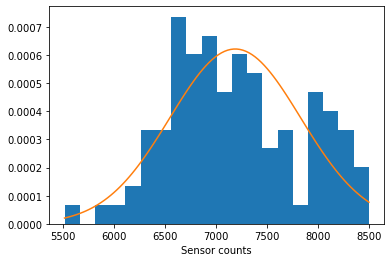

mean = 7187, sigma = 641, resolution = 0.089243


In [70]:
  

#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_array, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_array) # get mean and standard deviation  
xmin, xmax = min(nph_array), max(nph_array)  
lnspc = np.linspace(xmin, xmax, len(nph_array))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))



##print(nsec_1GEM_array)
#plt.hist(nsec_1GEM_array,num_bins, density=True)
##plt.xlim(xmin=0, xmax = 1000)
##plt.ylim(ymin=0, ymax = 10000)
#EXP = expon.fit(nsec_1GEM_array, floc=0)
#print(EXP)
#xmin, xmax = min(nsec_1GEM_array), max(nsec_1GEM_array)
#lnspc2 = np.linspace(0, 600, 100)
##print(lnspc2)
#pdf_exp = stats.expon.pdf(lnspc2,*EXP)
#plt.plot(lnspc2, pdf_exp, label="exp")

#plt.show()

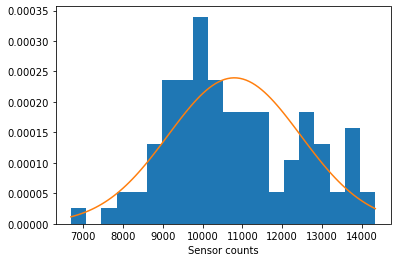

mean = 10797, sigma = 1664, resolution = 0.154199


In [71]:
#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_nosat, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_nosat) # get mean and standard deviation  
xmin, xmax = min(nph_nosat), max(nph_nosat)  
lnspc = np.linspace(xmin, xmax, len(nph_nosat))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))